In [1]:
# Import Packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as wgt
import tableMaker

# Reimport changes when editing LiuInt or tableMaker
import importlib
importlib.reload(tableMaker)

<module 'tableMaker' from '/home/jaredwp91/Research/mnt/inferno/codes/TableMakerMain/postGit/tableMaker.py'>

# Comparison to experimental results

In [2]:
#----- Load in data

from tableMaker import *
path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)
data_output = get_data_files(path, Lvals, tvals)

In [ ]:
#----- Create T Table
phi = 'T'
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi, \
                                    numXim = 10, numXiv = 10, get_data_files_output = data_output)

In [ ]:
#----- Create h & c tables
phi = 'h'
h_table, h_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi, \
                                                get_data_files_output = data_output)
phi = 'c'
c_table, c_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi, \
                                                get_data_files_output = data_output)
print('h & c tables complete')

In [ ]:
#----- Create interpolators
Ih = tableMaker.createInterpolator(h_table, h_indices)
Ic = tableMaker.createInterpolator(c_table, c_indices)
It = tableMaker.createInterpolator(table, indices)

In [ ]:
#----- Define function to get T(xim, xiv, h, c) from table
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih, Ic, Lbounds, tbounds, hc_avg = 10**(-5))
    return It(xim, xiv, L, t)

In [ ]:
#----- Import DOL-processed data
cols = "r, F, Frms, C, H, T, O2, N2, H2, H2O, CH4, CO, CO2, OH, NO" #from data file
ximcol = 1
xivcol = 2
hcol = 4
ccol = 3
tcol = 5

fileNames = [r"D075.Yall_proc", r"D30.Yall_proc", r"D60.Yall_proc", \
             r"D15.Yall_proc", r"D45.Yall_proc", r"D75.Yall_proc"]
filePath = r"./aPriori/processed/pmD.scat/"

t_table_data_all = np.empty(len(fileNames), dtype=np.ndarray)
data = np.empty((len(fileNames)), dtype=np.ndarray)

for j in range(len(fileNames)):
    netPath = filePath+fileNames[j]
    data[j] = np.loadtxt(netPath)[1:-1].T      #Indexing piece in the middle avoids xim=0
    t_data_table = np.ones(len(data[j][0]))*-1 #Initialize to store table-computed data
    
    for i in range(len(data[j][0])):
        xim = data[j][ximcol][i]
        xiv = data[j][xivcol][i]
        h   = data[j][hcol][i]
        c   = data[j][ccol][i]
        t_data_table[i] = T_table(xim, xiv, h, c)
    t_table_data_all[j] = t_data_table

print('done')

In [ ]:
colors = ['#FF0000', '#FFA500', '#00FF00', '#0000FF', '#4B0082', '#000000']

omit = 0 #number of plots to show simultaneously
for i in range(len(data)-omit):
    t_data_experiment = data[i][tcol]
    r = data[i][0]
    plt.plot(r, t_data_experiment, 'o', \
             color = colors[i])
    plt.plot(r, t_table_data_all[i], label = f"{fileNames[i]}", \
             color = colors[i])
plt.title("Table vs. Experiment")
plt.ylabel("Temperature (K)")
plt.xlabel(r"Radial Position")
plt.xlim((0,75))
plt.ylim((0,2000))
plt.legend();
print("""Dots = Experimental
Lines = Table""")

# Benchmark Table Creation (Temperature)

In [38]:
#Table Test: time the creation of a temperature table    
import time

Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)
path = r"./data"

#----- Create T Table
phi = 'T'
start = time.process_time()
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi)
elapsed = (time.process_time()-start)
print(f"Time elapsed to process temperature table = {elapsed:.2f} seconds")

#----- Creatte h & c tables
phi = 'h'
h_table, h_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi)
phi = 'c'
c_table, c_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi)
print('h & c tables complete')

Time elapsed to process temperature table = 38.72 seconds
h & c tables complete


# Interpolator Test

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([[0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.0625  , 0.125   , 0.1875  , 0.25    ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.      , 0.      , 0.      , 0.      ]]), [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]
h test:
1.623333663604268e-05
1.6233336622550786e-05

c test:
0.11767264348054293
0.11767264365928067

T test:
876.7550330773894
876.7550338275776

Equivalent, so initial test is successful.


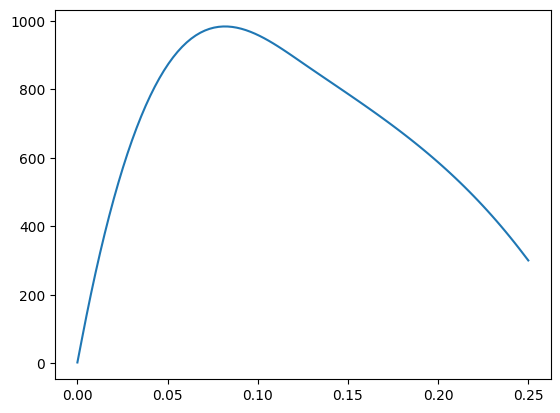

In [43]:
# Test the Interpolator
Ih = tableMaker.createInterpolator(h_table, h_indices)
Ic = tableMaker.createInterpolator(c_table, c_indices)
It = tableMaker.createInterpolator(table, indices)

print(h_indices)
print("h test:")
htest = h_table[2][2][1][1]  # means xim = 0.25, xiv = 0.046875, L = 0.004, t = 1
print(htest) 
xim = 0.5
xiv = 0.125
L = 0.004
t = 1
print(Ih(xim, xiv, L, t))
print()

print("c test:")
ctest = c_table[2][2][1][1]
print(ctest)
print(Ic(xim, xiv, L, t))
print()

print("T test:")
ttest = table[2][2][1][1]
print(ttest)
print(It(xim, xiv, L, t))
print()

print("Equivalent, so initial test is successful.")
xivs = np.linspace(0, 0.25, 100)
Tarrtest = np.nan_to_num([It(xim, v, L, t) for v in xivs], nan=-1)
plt.plot(xivs, Tarrtest);

# (h,c) $\rightarrow$ (L,t) test

In [26]:
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
hval = htest
cval = ctest

ans = Lt_hc(hval, cval, xim, xiv, Ih, Ic, Lbounds, tbounds, hc_avg = 10**5)

print(f"Goal L = {L:.6f} | Solved L = {ans[0]:.6f}")
print(f"Goal t = {t:.6f} | Solved t = {ans[1]:.6f}")

Goal L = 0.004000 | Solved L = 0.002000
Goal t = 1.000000 | Solved t = 0.999764


# Plotting with Fixed $\xi_m$, $\xi_v$

## Create Data

In [6]:
#----- Plot h(L, t) to see relationship
#Create data
xim = 0.4  #arbitrary
xiv = 0.12 #arbitrary
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

x, y = np.meshgrid(Ls, ts)
hs = np.zeros_like(x)
cs = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        hs[i, j] = Ih(xim, xiv, x[i, j], y[i, j])
        cs[i, j] = Ic(xim, xiv, x[i, j], y[i, j])

z1 = hs
z2 = cs

NameError: name 'Ih' is not defined

## extractContour Function

In [7]:
def extractContour(zval, data):
    """
    Extracts the contour line data for Z = z(x,y). 
    Inputs: 
        zval: contour's value of z
        data: tuple or array with 3 elements (in order):
            X: meshed array of x data points (2D
            Y: meshed array of y data points (2D)
                NOTE: xdata, ydata = np.meshgrid(xdata ydata)
            Z: array of z data points (2D)
    Outputs: 
        lines: numpy array of points [x,y,z] 
    Example usage: 
        >>> zval   = 0.10
        >>> X, Y   = np.meshgrid(xdata, ydata)
        >>> data   = (X, Y, zdata)
        >>> points = extractContour(zval, data)
        >>> fig    = plt.figure()
        >>> ax     = fig.add_subplot(111, projection='3d')
        >>> ax.scatter(points[:,0], points[:,1], points[:,2])
    """
    xdat, ydat, zdat = data
    X, Y = np.meshgrid(xdat, ydat)
    contour_lines = plt.contour(xdat, ydat, zdat, levels = (zval,))

    # Find intersection points of contour lines with the plane
    lines = []
    for line_collection in contour_lines.collections:
        for path in line_collection.get_paths():
            vertices = path.vertices
            for point in vertices:
                xpt, ypt = point
                lines.append([xpt, ypt, zval])

    plt.close()
    return np.array(lines)

## Creating Plot

c:  0.11623272094974695
h:  7.644147664726421e-07


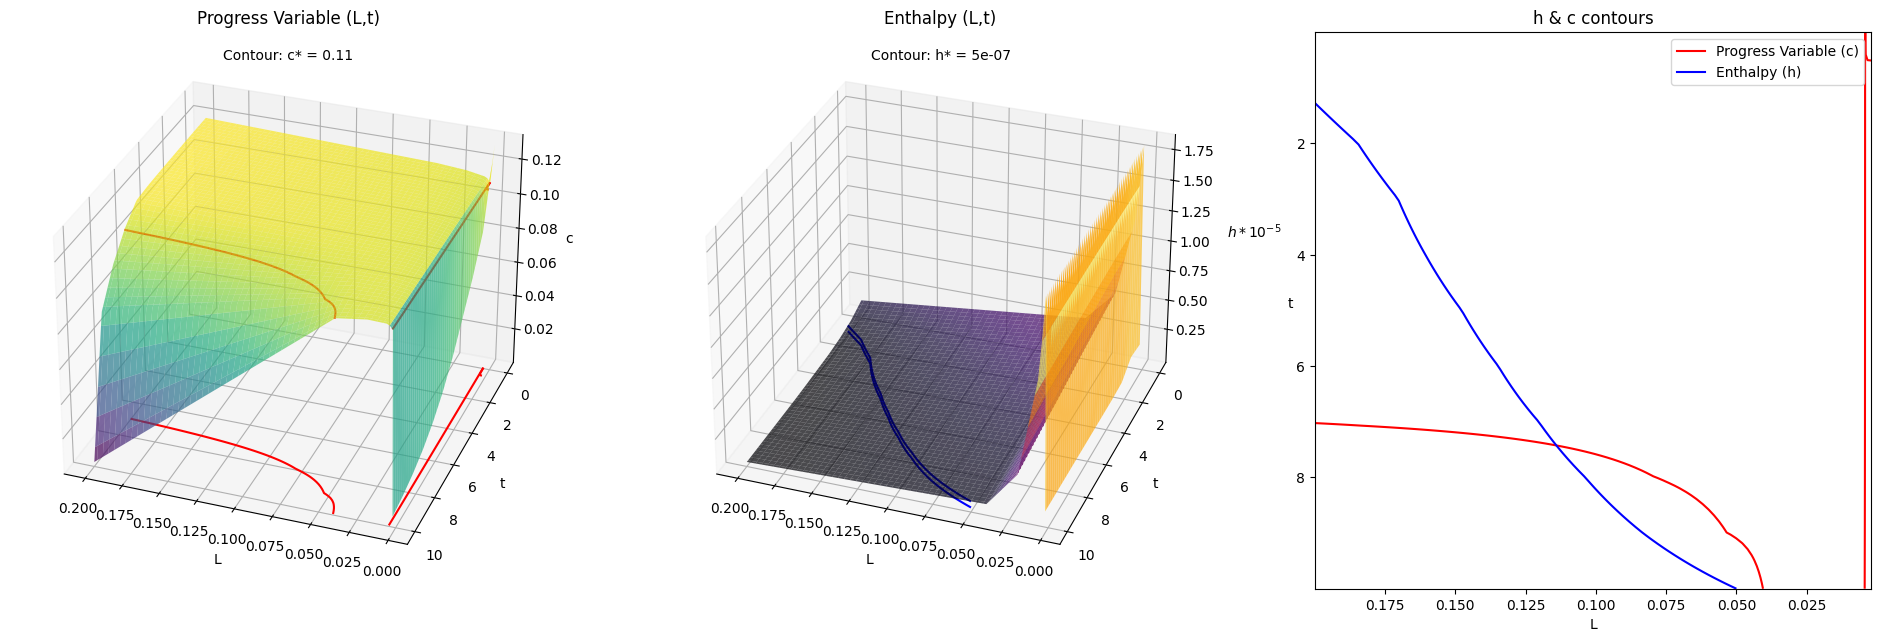

In [8]:
from matplotlib.lines import Line2D
xim = 0.4  #arbitrary
xiv = 0.12 #arbitrary
cknown = Ic(xim, xiv, 0.1, 6)
hknown = Ih(xim, xiv, 0.1, 6)
print("c: ", cknown)
print("h: ", hknown)

#----- General Formatting
fig = plt.figure(figsize = (20,20))
ccol = 'r'
hcol = 'b'
alp = 0.7 #transparency
#plt.rcParams.update({'font.size': 10})  #global font size update

#----- Plot Progress Variable
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(x,y,cs, cmap='viridis', alpha = alp)

#Add contours
cval = 0.11
contour_lines = ax.contour(x, y, cs, zdir='z', levels=[cval], colors=ccol)
contour_bottom = ax.contour(x, y, cs, zdir='z', levels=[cval], colors=ccol, offset = 0)

#Formatting
ax.set_title("Progress Variable (L,t)")
ax.text2D(0.5, 0.95, f'Contour: c* = {cval}', transform=ax.transAxes, ha='center')
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.set_zlabel("c")
ax.view_init(30, 110)

#----- Plot Enthalpy
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x,y,hs, cmap='inferno', alpha = alp)

#Add contours
hval = 5e-7
contour_lines = ax.contour(x, y, hs, zdir='z', levels=[hval], colors=hcol)
contour_bottom = ax.contour(x, y, hs, zdir='z', levels=[hval], colors=hcol, offset = 0)

#Formatting
ax.set_title("Enthalpy (L,t)")
ax.text2D(0.5, 0.95, f'Contour: h* = {hval}', transform=ax.transAxes, ha='center')
ax.set_xlabel("L")
#ax.set_xticks(np.arange(Lbounds[0], Lbounds[1], 0.04))
ax.set_ylabel("t")
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r"$h*10^{-5}$", rotation = 0, labelpad = 20)
ax.view_init(30, 110)

#----- Plot Projections Only
ax = fig.add_subplot(133)

#Get projection data
cproj = ax.contour(x,y,cs, levels = [cval], colors = ccol)
hproj = ax.contour(x,y,hs, levels = [hval], colors = hcol)
contour_aspect = (Lbounds[1]-Lbounds[0])/(tbounds[1]-tbounds[0])
ax.set_aspect(contour_aspect)
ax.set_title("h & c contours")
ax.set_xlabel("L")
ax.set_ylabel("t", rotation = 0)
ax.invert_xaxis()
ax.invert_yaxis()
legend_elements = [
    Line2D([0], [0], color=ccol, label="Progress Variable (c)"),
    Line2D([0], [0], color=hcol, label="Enthalpy (h)")
]

#----- Add legend with the proxy artists
ax.legend(handles=legend_elements)

#----- Save and show final result
plt.tight_layout(pad = 5)
save = False
if save:
    plt.savefig(f'3DplotsANDcontour_c_{cval}_h_{hval:.0e}.png',bbox_inches='tight')  # Save as a PNG file
plt.show();

## Plot Temperature Snapshots: fixed xim, xiv
### Generate Data

In [8]:
ximT = 0.05
xivT = ximT*(1-ximT)/2 #1/2 of max variance
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        Ts[i, j] = It(xim, xiv, xT[i, j], yT[i, j])

### Plotting

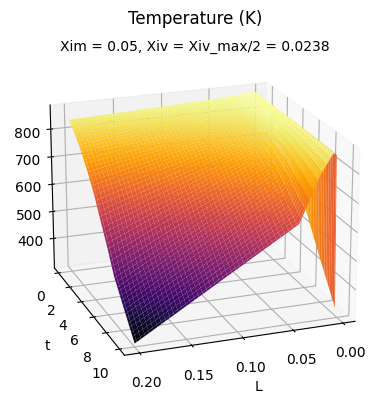

In [9]:
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim = 30)
ax.set_title("Temperature (K)")
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.view_init(20, 70)
ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
ax.plot_surface(xT, yT, zdata, cmap='inferno')
ax.text2D(0.5, 0.95, rf'Xim = {ximT:.2f}, Xiv = Xiv_max/2 = {xivT:.4f}', transform=ax.transAxes, ha='center')

plt.savefig(f'./figures/3DTemperature_xim_{ximT:.2f}_xiv_{xivT:.4f}.png',bbox_inches='tight')  # Save as a PNG file

### Animating

In [17]:
#Create Data
ximTarr = np.linspace(0.01, 0.99, 10)
xivTarr = ximTarr*(1-ximTarr)/2 #1/2 of max variance
num_points = 30
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros((len(ximTarr), len(Ls), len(ts)))

for k in range(len(ximTarr)):
    xim = ximTarr[k]
    xiv = xivTarr[k]
    print(k)
    for i in range(num_points):
        for j in range(num_points):
            Ts[k,i,j] = It(xim, xiv, xT[i, j], yT[i, j])

0
1
2
3
4
5
6
7
8
9


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  0


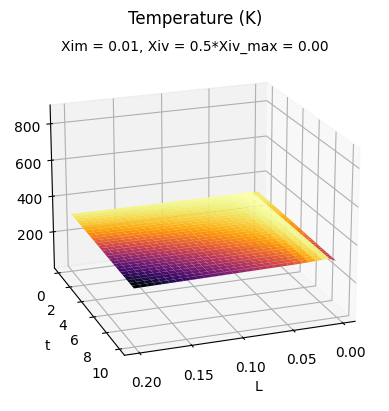

In [20]:
from matplotlib import animation

#Animate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

animData = Ts
# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(animData):
        frame = 2*len(animData)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.set_title("Temperature (K)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.view_init(20, 70)
    ax.set_zlim(bottom=np.min(animData), top=np.max(animData))
    surf = ax.plot_surface(xT, yT, animData[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {ximTarr[frame]:.2f}, Xiv = 0.5*Xiv_max = {xivTarr[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(animData), interval=200)

# Save the animation as a GIF
ani.save(f'Temperature_VariableXimXiv.gif', writer='pillow', fps=5)

## Plot Temperature Snapshots: fixed L, t
### Generate Data

In [133]:
LT = 0.04
tT = 1
num_points = 100
ximMax = 0.99
ximTs = np.linspace(0.01, ximMax, num_points)
xivTs = np.transpose(np.array([np.linspace(1e-4,xi*(1-xi)-1e-4, num_points) for xi in ximTs]))

#ximTmesh, xivTmesh = np.meshgrid(ximTs, np.hstack(xivTs))
ximTmesh, nichts = np.meshgrid(ximTs, np.linspace(0,1,num_points))
Ts = np.zeros_like(ximTmesh)

for i in range(num_points):
    if i%10 == 0:
        print(i)
    for j in range(num_points):
        Ts[i, j] = It(ximTmesh[i,j], xivTmesh[i,j], LT, tT)

0
10
20
30
40
50
60
70
80
90


### Plotting - HAVING PROBLEMS

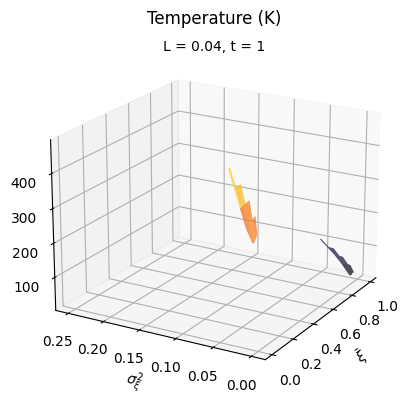

In [134]:
zdata = Ts #np.nan_to_num(Ts, nan=300)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim = 30)
ax.set_title("Temperature (K)")
ax.set_xlabel(r"$\bar{\xi}$")
ax.set_ylabel(r"$\sigma_{\xi}^2$")
ax.view_init(20, 210)
#ax.set_zlim(bottom=-100, top=1400)
ax.plot_surface(ximTmesh, xivTs, zdata, cmap='inferno')
ax.text2D(0.5, 0.95, f'L = {LT}, t = {tT}', transform=ax.transAxes, ha='center')

plt.savefig(f'./figures/3DTemperature_L_{LT}_t_{tT}.png',bbox_inches='tight')  # Save as a PNG file

## Animating

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(zdata):
        frame = 2*len(zdata)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Temperature")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("Temperature (K)")
    ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
    surf = ax.plot_surface(x, y, zdata[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(zdata), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

## Interactive Plots

In [10]:
#----- Interactive plots
def interact1(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z1, cmap='inferno')
    contour_lines = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.view_init(theta, phi)
    plt.show();

def interact2(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z2, cmap='viridis')
    contour_lines = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    
    ax.view_init(theta, phi)
    plt.show();


#wgt.interact(interact1, theta=(0,90), phi=(0,360), z)
wgt.interact(interact2, theta=(0,90), phi=(0,360), z = np.arange(0.01, 0.13, 0.01))

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

<function __main__.interact2(theta, phi, z)>

# Animate over values of $\xi_{mean}$
### WARNING: data  population may be incorrect. See method used above. 

In [20]:
#Create data
xim = np.linspace(0.01,0.99,20)
xiv = xim*(1-xim)/2 #Set xiv to be 1/2 of the maximum value for a given xim.
Ls = np.linspace(min(Lvals)+1e-3, max(Lvals)-1e-3, 50)
ts = np.linspace(min(tvals)+1e-3, max(tvals)-1e-3, 50)
hs = np.ones((len(xim), len(Ls), len(ts)))
cs = np.ones((len(xim), len(Ls), len(ts)))
for i in range(len(xim)):
    print(i)
    for l in range(len(Ls)):
        for t in range(len(ts)):
            hs[i,l,t] = Ih(xim[i], xiv[i], Ls[l], ts[t])
            cs[i,l,t] = Ic(xim[i], xiv[i], Ls[l], ts[t])

print("Checkpoint1")
x, y = np.meshgrid(Ls, ts)
z1 = hs
z2 = cs

0
1
2
3
4


/home/jaredwp91/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Checkpoint1


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


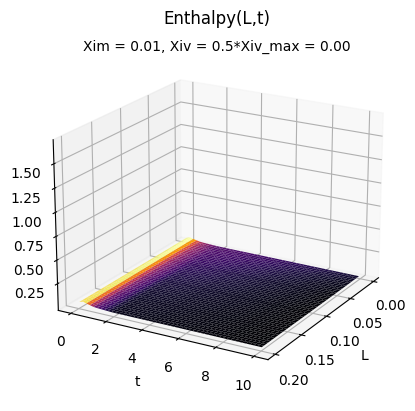

In [27]:
# Animate the plot for enthalpy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z1):
        frame = 2*len(z1)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.set_zlim(bottom=np.min(z1), top=np.max(z1))
    surf = ax.plot_surface(x, y, z1[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z1), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


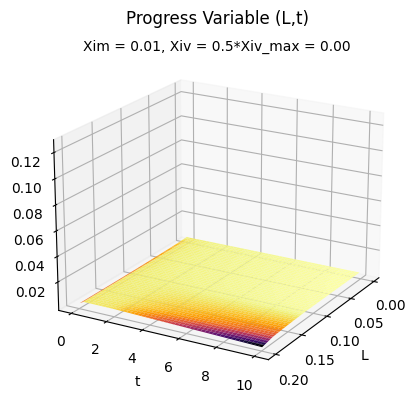

In [28]:
# Animate the plot for progress variable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z2):
        frame = 2*len(z2)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    ax.set_zlim(bottom=np.min(z2), top=np.max(z2))
    surf = ax.plot_surface(x, y, z2[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z2), interval=200)

# Save the animation as a GIF
ani.save(f'ProgressVariable_VariableXimXiv.gif', writer='pillow', fps=5)

# Archive

### findClosestZ code (obsolete)

In [ ]:
def findClosestZ(zval, zdata):
    """
    OBSOLETE: unneeded now. Determined that the issue with contour data extraction was to do with the 3D plot. 
    Finds the value z in zdata closest to the inputted zval.
    """
    zdata = zdata.flatten()
    errSqMin = 100
    z = None
    for pt in zdata:
        error = (zval-pt)**2
        if error < errSqMin:
            errSqMin = error
            z = pt
    return z

### solveIntersection code (obsolete)

In [ ]:
def solveIntersection(val, interp, xim, xiv, Lbounds, tbounds, resolution = 20):
    """
    Solves for a set of points (L,t) that fulfill
        val = interp(xim, xiv, L, t)

    Inputs:
        val: value to be solved for (c or h)
        interp: interpolator function of the form interp(xim, xiv, L, t)
        xim: value of xi mean
        xiv: value of xi variance
        Lbounds: tuple describing min and max valid L value
        tbounds: tuple describing min and max valid t value
        resolution: number of Ls and ts to include in search grid (solver speed decreases with resolution^2)
    """          
    def solve(L, t):
        #----------- Ensure value is within interpolator's bounds
        buffer = 1e-8
        if L < Lbounds[0]:
            L = Lbounds[0] + buffer
        if L > Lbounds[1]:
            L = Lbounds[1] - buffer
        if t < tbounds[0]:
            t = tbounds[0] + buffer
        if t > tbounds[1]:
            t = tbounds[1] - buffer
        
        return interp(xim, xiv, L, t) - val

    Ls = np.linspace(Lbounds[0], Lbounds[1], resolution)
    ts = np.linspace(tbounds[0], tbounds[1], resolution)
    #Ls = np.linspace(0.15, 0.2, resolution) #DEBUGGING
    #ts = np.linspace(8,10,resolution) #DEBUGGING

    
    solutions = []
    for i in range(resolution):
        #For each t... 
        t = ts[i]
        for j in range(resolution):
            # ...use each L in the array as a guess value to find each solution.
            Lguess = Ls[j]
            Lsolved = least_squares(solve, Lguess, args = (t,), bounds = Lbounds).x
            solutions.append([Lsolved, t, val])
            
    return solutions

### Contour Plot Demo

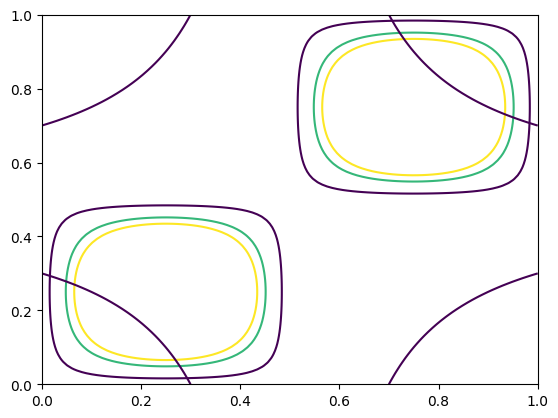

In [185]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X,Y = np.meshgrid(x,y)

Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)
W = (X-0.5)**2 * (Y-0.5)**2

plt.contour(X,Y,Z, levels = [0.1,0.3,0.4])
plt.contour(X,Y,W, levels = [0.01]);

### Rotating Plot Animation

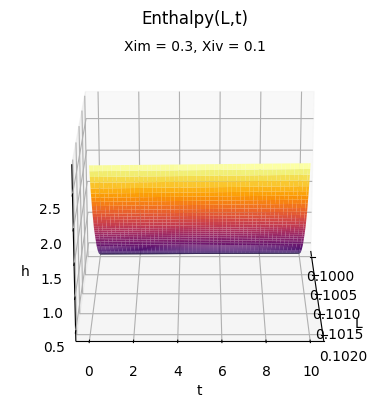

In [12]:
from matplotlib import animation

#----- Animate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim=4*frame)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    surf = ax.plot_surface(x, y, z1, cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim}, Xiv = {xiv}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=90, interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_xim{xim}_xiv{xiv}.gif', writer='pillow', fps=15)

### Demonstration (using old code)

In [19]:
import LiuInt as LI

#Set constants, get indices
phi = 'T'
ξm = 0.26
ξv = 0.049575
L = 0.002
t = 9
ximi, xivi, Li, ti = valToIndex(ξm, ξv, L, t, indices)

#----- Example with one file and one phi
#Manual Computation
fileName = f'L_{L}U_00{t}.dat'
file1_Tfunc = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameNew/flame/run", phi, fileName)
phiAvg = LI.IntegrateForPhiBar(ξm, ξv, file1_Tfunc)
print(f"Average {phi} from data in {fileName} (calculated directly) = {phiAvg:.2f} K")
#Tabulated Values
tableVal = table[ximi][xivi][Li][ti]
print(f"Average {phi} from data in {fileName} (tabulated)           = {tableVal:.2f} K\n")


#----- Example with multiple files and one phi
#Manual computation
phiBarVector = np.vectorize(LI.IntegrateForPhiBar)
file1_Tfunc = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameNew/flame/run", phi)
phiAvg = {key: phiBarVector(ξm, ξv, file1_Tfunc[key]) for key in list(file1_Tfunc)}

#----- Display Setup
print(f"Filename"+" "*(21-len("Filename"))+f"{phi}_avg (calculated)"+" "*8+f"{phi}_avg (tabulated)")
print("----------------------------------------------------------------")

#----- Tabulated Values
vals = []
for i in range(len(indices[2])):
    length = indices[2][i]
    for j in range(len(indices[3])):
        time = indices[3][j]
        ximi, xivi, li, ti = valToIndex(ξm, ξv, length, time, indices)
        SU = ['S', 'U']
        zeros = "0"*(3-len(str(time)))
        key = f'L_{length}{SU[time != 0]}_{zeros}{time}.dat'
        calculated = f"{phiAvg[key]:.2f} K"
        print(f"{key}"+" "*(25-len(key))+calculated+" "*(25-len(calculated))+f"{table[ximi][xivi][li][ti]:.2f} K")

Average T from data in L_0.002U_009.dat (calculated directly) = 407.32 K
Average T from data in L_0.002U_009.dat (tabulated)           = 406.88 K

Filename             T_avg (calculated)        T_avg (tabulated)
----------------------------------------------------------------
L_0.2S_000.dat           1201.25 K                1215.25 K
L_0.2U_001.dat           1144.85 K                1157.46 K
L_0.2U_002.dat           1075.50 K                1086.47 K
L_0.2U_003.dat           990.26 K                 999.30 K
L_0.2U_004.dat           891.83 K                 898.82 K
L_0.2U_005.dat           769.93 K                 774.74 K
L_0.2U_006.dat           654.08 K                 657.56 K
L_0.2U_007.dat           534.42 K                 538.15 K
L_0.2U_008.dat           469.16 K                 472.69 K
L_0.2U_009.dat           398.01 K                 400.26 K
L_0.2U_010.dat           301.58 K                 301.60 K
L_0.04S_000.dat          1238.27 K                1252.25 K
L_0.04U_001

/tmp/ipykernel_255/579430965.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  key = f'L_{length}{SU[time != 0]}_{zeros}{time}.dat'


KeyError: 'L_0.002S_000.dat'

### Benchmarking (unedited)

In [ ]:
from scipy.optimize import curve_fit

# Benchmarking
import time
import matplotlib.pyplot as plt
%matplotlib inline

phi = 'T'
times = np.zeros(8)
for i in range(len(times)):
    start = time.process_time()
    table, indices = lookupTable("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run",
                                phi, resolution = i+1)
    t = (time.process_time() - start)
    times[i] = t


res = np.arange(1,9,1)
plt.plot(res, times, '.', label = "Observed Values")
plt.xlabel("Resolution")
plt.ylabel("Processing time (s)")
plt.title("Table Creation Time")

def func(x, a, b):
    return a*x**2 + b*x
p1, p2 = curve_fit(func, res, times)[0]

lin = np.linspace(1,8,100)
plt.plot(lin, func(lin, p1, p2), label = f"t = ({p1:.2f}) r^2 + ({p2:.2f}) r")
plt.legend();

print(f"Valid Xims and Xivs: {indices[1]}")
print()
print(f"Valid Ls and ts: {indices[3]}")

### Other

In [ ]:
def valToIndex(xim, xiv, L, t, indices, thresh = 1e-4):
    """
    DEPRECATED. This functionality is now contained in "createInterpolator"
    Converts values of Xim, Xiv, L, and t to indices for the table resulting from the lookupTable function.
    Inputs:
        xim = value of Xim
        xiv = value of Xiv
        L = value of length scale
        t = value of time step
        indices = second output array of lookupTable
        thresh: Accounts for marginal roundoff error due to linspace
            For example, inputting xiv = 0.0045 in this function will match with tabulated xiv values 0.0045 +- thresh
    Outputs are the indices of the relevant value. For example:
        i_Xim = index of the inputted Xim value in the lookup table
    """
    i_Xim = "err: val not found"
    i_Xiv = "err: val not found"
    i_L = "err: val not found"
    i_t = "err: val not found"

    for x in range(len(indices[0])):
        if (indices[0][x]-xim) <= thresh:
            i_Xim = x
            for y in range(len(indices[1][i_Xim])):
                if (indices[1][x][y]-xiv) <= thresh:
                    i_Xiv = y
    for z in range(len(indices[2])):
        if indices[2][z] == L:
            i_L = z
    for time in range(len(indices[3])):
        if indices[3][time] == t:
            i_t = time
    return i_Xim, i_Xiv, i_L, i_t

In [ ]:
#Testing Grounds

#Array masking
a = np.ones(10)*(-1)
for i in range(len(a)-1):
    a[i] = np.random.rand()
aNew = a[a!=-1]

#Regex
pattern = r"L_([\d.]+)[SU]_([\d.]+)\.dat"
candidates = ["L_0.03U_198.dat", "L_0.002S_299.dat", "L0990U900.dat"]
for c in candidates:
    print(search(pattern, c))

L = 0.03
pattern2 =  f"L_{L}[SU]_[\d]*\.dat"
arr2 = ["L_0.02S_001.dat", "L_0.02S_003.dat", "L_0.02S_002.dat", "L_0.02U_001.dat", "L_0.03S_001.dat"]
print("Here", len([name for name in arr2 if match(pattern2, name)]))
arr = [0.1, 0.4, 0.5, 0.2, 0.7, 0.15]
print(np.sort(arr)[::-1])

In [ ]:
# Fidelity Test: trying to determine the behavior of the BetaPDF near 0 and 1
import LiuInt as LI
function = phiFuncs("../flame/run", 'T', fileName = 'L_0.002U_24.dat')

#For what value of xim is xim = 0 = x a good approximation? 
#Hypothesis: Something beneath 1e-6 will work fine. 
Min = -1
xim = np.logspace(0, Min,10)
xiv = np.logspace(0, Min,10)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
  
# Creating 2-D grid of features 
[X, Y] = np.meshgrid(xim, xiv) 
  
fig, ax = plt.subplots(1, 1) 

Z = np.zeros((len(xim), len(xiv)))
for i in range(len(xim)):
    for j in range(len(xiv)):
        Z[i,j] = LI.IntegrateForPhiBar(xim[i], xiv[j], function)

# plots filled contour plot 
ax.contourf(X, Y, Z) 
  
ax.set_title('Predicted values') 
ax.set_xlabel('Xim') 
ax.set_xscale('log')
ax.set_ylabel('Xiv')
ax.set_yscale('log')
cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
  
plt.show() 
plt.savefig('Fidelity_min.png', dpi=300, bbox_inches='tight')

In [14]:
# First attempt to show interaction of h(L,t) and c(L,t). 
# Plot isn't useful because of scaling differences: No aparent 
#        meaning to the intersections
def interact(theta, phi, l, t):
    def h(xim, xiv):
        ijko = valToIndex(xim, xiv, l, t, h_indices)
        i = ijko[0]
        j = ijko[1]
        k = ijko[2]
        o = ijko[3]
        return h_table[i][j][k][o]
    hvect = np.vectorize(h)

    def c(xim, xiv):
        ijko = valToIndex(xim, xiv, l, t, c_indices)
        i = ijko[0]
        j = ijko[1]
        k = ijko[2]
        o = ijko[3]
        return c_table[i][j][k][o]
    cvect = np.vectorize(c)

    hxims = h_indices[0]
    hxivs = h_indices[1]
    cxims = c_indices[0]
    cxivs = c_indices[1]

    HXM, HXV = np.meshgrid(hxims, hxivs)
    H = hvect(HXM, HXV)
    CXM, CXV = np.meshgrid(cxims, cxivs)
    C = cvect(CXM, CXV)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(CXM, CXV, C, rstride=1,cstride=1,
                    cmap='plasma', edgecolor='none')
    ax.plot_surface(HXM, HXV, H, rstride=1,cstride=1,
                    cmap = 'viridis', edgecolor='none')
    ax.set_xlabel('Xim')
    ax.set_ylabel('Xiv')
    ax.set_zlabel("h or c")
    ax.set_title("h(Xim, Xiv) and c(Xim, Xiv)")
    ax.view_init(theta, phi)
    plt.show()

wgt.interact(interact, theta=(0,90), phi=(0,360), l = (0.02,0.02), t = (6,6))

print("Hot colors are c, Cooler colors are h")

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

Hot colors are c, Cooler colors are h


In [57]:
# Plot an interactive version of  phi(L,t)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as wgt

def interact(theta, phi):
    #Temperature in terms of l and t
    def f(l, t):
        ij = valToIndex(-1,-1,l,t, indices)
        i = ij[2]
        j = ij[3]
        return table[2][2][i][j] #Arbitrarily use the third value of xim and xiv
    fvect = np.vectorize(f)
    
    x = indices[2] #Ls
    y = indices[3] #ts
    
    X, Y = np.meshgrid(x, y)
    Z = fvect(X, Y)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_xlabel('L')
    ax.set_ylabel('t')
    ax.set_zlabel('Temperature')
    ax.set_title('Temp(L,t)')
    ax.view_init(theta, phi)
    plt.show()

wgt.interact(interact, theta=(0,90), phi=(0,360));

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…